# Web Scraping scryfall.com

# Introduction

Hello, I'm Evan Freeman. For fun, and to work on some new skillsets (including web scraping and regex), I'm going to try to get some data from a website called scryfall.com. This website houses all sorts of useful info about a card game called Magic the Gathering. Yes, it's a super nerdy game. But its over 25 years old, and there's all sorts of interesting data we can work with about it, including card properties and prices!

# Setup

In [2]:
import re
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# A Better Way

So, I tried a certain approach when I first started, which you can see at the end. I'm leaving it in for academic purposes. But, I've since discovered a better way, which you can see here.

The sets page has some good stuff! Like number of cards and release date! I need to get that!!!

Let's inspect the page in Chrome to see which tag has the info I want.

It looks like each row is contained within a 'tr' tag. So let's dissect one of these.

In [3]:
def clean_text(text):
    """A regex to clean up text, by removing formatting characters and leading or trailing whitespace"""

#     text = re.sub(r'([\n])|[\r]|(^\s+)|(\s+$)', '', text) # Meant to be a combined regex, not working
    text = re.sub(r'[\n]', '', text) # Delete line breaks
    text = re.sub(r'[\r]', '', text) # Delete carriage returns with a space
    text = re.sub(r'(^\s+)|(\s+$)', '', text) # Delete all leading or trailing whitespace
    return text

# Ya, I could probably combine all these into one regex, and compile it. But I'm in a hurry

In [4]:
r = requests.get(r'https://www.scryfall.com/sets')

sets_data = r.text

sets_soup = BeautifulSoup(sets_data)

In [6]:
# I read that its MUCH more efficient to put all the data into a list or dict, then append to df or create a df

lst = []

for row in sets_soup.find_all('tr')[1:]:
    boxes = row.find_all('td')
    info = boxes[0].text.rsplit(' ', 1) + [boxes[1].text, boxes[2].text, boxes[1].find('a').get('href')]
    info = [clean_text(text) for text in info]
    lst.append(info)

lst[:10]

[['Historic Anthology 2',
  'HA2',
  '22',
  '2020-03-12',
  'https://scryfall.com/sets/ha2'],
 ['Unsanctioned', 'UND', '96', '2020-02-29', 'https://scryfall.com/sets/und'],
 ['Unsanctioned Tokens',
  'TUND',
  '6',
  '2020-02-29',
  'https://scryfall.com/sets/tund'],
 ['Theros Beyond Death',
  'THB',
  '358',
  '2020-01-24',
  'https://scryfall.com/sets/thb'],
 ['Theros Beyond Death Promos',
  'PTHB',
  '136',
  '2020-01-24',
  'https://scryfall.com/sets/pthb'],
 ['Theros Beyond Death Tokens',
  'TTHB',
  '14',
  '2020-01-24',
  'https://scryfall.com/sets/tthb'],
 ['MagicFest 2020',
  'PF20',
  '6',
  '2020-01-01',
  'https://scryfall.com/sets/pf20'],
 ['Judge Gift Cards 2020',
  'J20',
  '6',
  '2020-01-01',
  'https://scryfall.com/sets/j20'],
 ['Secret Lair Drop',
  'SLD',
  '60',
  '2019-12-02',
  'https://scryfall.com/sets/sld'],
 ['Secret Lair Drop Promos',
  'PSLD',
  '34',
  '2019-12-02',
  'https://scryfall.com/sets/psld']]

In [7]:
sets = pd.DataFrame(lst, columns = ['name', 'abbreviation', 'num_cards', 'release_date', 'url'])
sets.num_cards = sets.num_cards.astype('int64')
sets.release_date = pd.to_datetime(sets.release_date)
sets

,name,abbreviation,num_cards,release_date,url
0,Historic Anthology 2,HA2,22,2020-03-12,https://scryfall.com/sets/ha2
1,Unsanctioned,UND,96,2020-02-29,https://scryfall.com/sets/und
2,Unsanctioned Tokens,TUND,6,2020-02-29,https://scryfall.com/sets/tund
3,Theros Beyond Death,THB,358,2020-01-24,https://scryfall.com/sets/thb
4,Theros Beyond Death Promos,PTHB,136,2020-01-24,https://scryfall.com/sets/pthb
...,...,...,...,...,...
576,Intl. Collectors’ Edition,CEI,302,1993-12-10,https://scryfall.com/sets/cei
577,Collectors’ Edition,CED,302,1993-12-10,https://scryfall.com/sets/ced
578,Unlimited Edition,2ED,302,1993-12-01,https://scryfall.com/sets/2ed
579,Limited Edition Beta,LEB,302,1993-10-04,https://scryfall.com/sets/leb


There's a few entries that don't have the full urls, so let's fix that.

In [8]:
mask = sets.url.apply(lambda site: site[:5] != 'https')
sets.loc[mask, 'url'] = sets.loc[mask, 'url'].apply(lambda site: 'https://scryfall.com' + site)

I could add info about which are "subsets", like promos and tokens, as those tags have an "indent class". But I won't worry about that now.

Once I learn SQL, that might be a better way to keep track of this stuff

# UND

Ok, let's try to grab all the info we can for one set. Then we'll generalize that technique for all sets. I guess we'll store each in a seperate data frame for now. Though I really am starting to think I need to use SQL.

Each set page has pictures of every card (by default). I can activate a checklist view by adding '?as=checklist', which makes it easier to get the data I want.

We end up with a similar html structure to the sets page, so I'll reuse most of that code.

In [9]:
r = requests.get(r'https://scryfall.com/sets/und?as=checklist')

data = r.text

soup = BeautifulSoup(data)

In [10]:
lst = []

for row in soup.find_all('tr')[1:]:
    boxes = row.find_all('td')
    info = [boxes[i].text for i in range(11)]
    info = [clean_text(text) for text in info]
    lst.append(info)

lst[:10]

[['UND',
  '1',
  'Adorable Kitten',
  '{W}',
  'Host Creature',
  'C',
  'EN',
  'Andrea Radeck',
  '$0.14',
  '€0.06',
  ''],
 ['UND',
  '2',
  'AWOL',
  '{2}{W}',
  'Instant',
  'C',
  'EN',
  'Stephen Tappin',
  '$0.13',
  '€0.05',
  ''],
 ['UND',
  '3',
  'Emcee',
  '{2}{W}',
  'Creature',
  'U',
  'EN',
  'Quinton Hoover',
  '$0.13',
  '€0.06',
  ''],
 ['UND',
  '4',
  'Flavor Judge',
  '{1}{W}',
  'Creature',
  'R',
  'EN',
  'Mike Burns',
  '$0.25',
  '€0.18',
  ''],
 ['UND',
  '5',
  'Frankie Peanuts',
  '{2}{W}{W}',
  'Lgd. Creature',
  'R',
  'EN',
  'Thomas M. Baxa',
  '$0.50',
  '€0.16',
  ''],
 ['UND',
  '6',
  'GO TO JAIL',
  '{W}',
  'Enchantment',
  'C',
  'EN',
  'Marco Teixeira',
  '$0.13',
  '€0.02',
  ''],
 ['UND',
  '7',
  'Humming-',
  '',
  'Creature',
  'C',
  'EN',
  'Mark Behm',
  '$0.14',
  '€0.08',
  ''],
 ['UND',
  '8',
  'Knight of the Hokey Pokey',
  '{W}{W}',
  'Creature',
  'C',
  'EN',
  'Kev Walker',
  '$0.12',
  '€0.02',
  ''],
 ['UND',
  '9',
  "Lo

In [9]:
cards = pd.DataFrame(lst, columns = ['set', 'collectors_num', 'name', 'cost', 'type', 'rarity', 'language', 'artist', 'usd', 'eur', 'tix'])
cards

,set,collectors_num,name,cost,type,rarity,language,artist,usd,eur,tix
0,UND,1,Adorable Kitten,{W},Host Creature,C,EN,Andrea Radeck,$0.14,€0.06,
1,UND,2,AWOL,{2}{W},Instant,C,EN,Stephen Tappin,$0.13,€0.04,
2,UND,3,Emcee,{2}{W},Creature,U,EN,Quinton Hoover,$0.16,€0.06,
3,UND,4,Flavor Judge,{1}{W},Creature,R,EN,Mike Burns,$0.26,€0.19,
4,UND,5,Frankie Peanuts,{2}{W}{W},Lgd. Creature,R,EN,Thomas M. Baxa,$0.58,€0.16,
...,...,...,...,...,...,...,...,...,...,...,...
91,UND,92,Swamp,,Basic Land,C,EN,Adam Paquette,$0.27,€1.99,
92,UND,93,Mountain,,Basic Land,C,EN,Rob Alexander,$0.18,€0.02,
93,UND,94,Mountain,,Basic Land,C,EN,Adam Paquette,$0.18,€1.85,
94,UND,95,Forest,,Basic Land,C,EN,Mark Poole,$0.26,€0.02,


We did it!! Now, time to get ALL THE CARDS!!!

# ALL THE CARDS!

In [10]:
start_time = time.time()

lst = []
for index, site in sets.url.iteritems():
    r = requests.get(f'{site}/?as=checklist')
    data = r.text
    soup = BeautifulSoup(data)
    
    for row in soup.find_all('tr')[1:]:
        boxes = row.find_all('td')
        info = [boxes[i].text for i in range(11)]
        info = [clean_text(text) for text in info]
        lst.append(info)
        
cards = pd.DataFrame(lst, columns = ['set', 'collectors_num', 'name', 'cost', 'type', 'rarity', 'language', 'artist', 'usd', 'eur', 'tix'])   
run_time = time.time() - start_time
print(f'--- This program took {run_time} seconds to run. ---')

--- This program took 596.163845539093 seconds to run. ---


In [11]:
cards.to_csv('D:/code/Data/scryfall/cards.csv', header = True)

In [12]:
cards

,set,collectors_num,name,cost,type,rarity,language,artist,usd,eur,tix
0,UND,1,Adorable Kitten,{W},Host Creature,C,EN,Andrea Radeck,$0.14,€0.06,
1,UND,2,AWOL,{2}{W},Instant,C,EN,Stephen Tappin,$0.13,€0.04,
2,UND,3,Emcee,{2}{W},Creature,U,EN,Quinton Hoover,$0.16,€0.06,
3,UND,4,Flavor Judge,{1}{W},Creature,R,EN,Mike Burns,$0.26,€0.19,
4,UND,5,Frankie Peanuts,{2}{W}{W},Lgd. Creature,R,EN,Thomas M. Baxa,$0.58,€0.16,
...,...,...,...,...,...,...,...,...,...,...,...
55253,LEA,291,Swamp,,Basic Land,C,EN,Dan Frazier,$19.41,€23.52,
55254,LEA,292,Mountain,,Basic Land,C,EN,Douglas Shuler,$29.23,€15.00,
55255,LEA,293,Mountain,,Basic Land,C,EN,Douglas Shuler,$19.98,€15.00,
55256,LEA,294,Forest,,Basic Land,C,EN,Christopher Rush,$30.73,€14.97,


# Data Cleaning and Exploration

Let's get our data into the correct data types, and clean up some things like weird symbols

In [53]:
cards = pd.read_csv('D:/code/Data/scryfall/cards.csv')

In [54]:
cards.isnull().sum()

Unnamed: 0            0
set                   0
collectors_num        0
name                  0
cost               7962
type                 12
rarity                0
language              0
artist               95
usd                9964
eur               15569
tix               23108
dtype: int64

In [55]:
cards.type.value_counts()

Creature                   20365
Instant                     6427
Sorcery                     5941
Enchantment                 5284
Artifact                    3652
                           ...  
Animal                         1
Token // Token Creature        1
Lgd. Snow Enchantment          1
Enchantment // Creature        1
土地                             1
Name: type, Length: 95, dtype: int64

In [88]:
cards.cost.value_counts()

{1}{W}                  1543
{1}{G}                  1451
{1}{U}                  1378
{1}{R}                  1285
{2}{R}                  1283
                        ... 
{4}{R}{R}{G}{G}            1
{7}{W}{W}{W}               1
{B/R}{B/R}{B/R}{B/R}       1
{3}{W}{W}{U}{U}            1
{2}{U/R}{U/R}              1
Name: cost, Length: 794, dtype: int64

In [92]:
cards.groupby('cost').count().sort_values(by = 'name')

,Unnamed: 0,set,collectors_num,name,type,rarity,language,artist,usd,eur,tix
cost,,,,,,,,,,,
{X}{Y}{Z}{R}{R},1,1,1,1,1,1,1,1,1,1,0
{7}{W}{W}{W},1,1,1,1,1,1,1,1,1,1,1
{2/G}{2/G}{2/G},1,1,1,1,1,1,1,1,1,1,1
{2/U}{2/U}{2/U},1,1,1,1,1,1,1,1,1,1,1
{7}{R},1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
{2}{R},1283,1283,1283,1283,1283,1283,1283,1283,1081,1004,808
{1}{R},1285,1285,1285,1285,1285,1285,1285,1285,1076,968,855
{1}{U},1378,1378,1378,1378,1378,1378,1378,1378,1163,1078,913


In [56]:
cards.groupby('artist').count().name.sort_values(ascending = False)

artist
John Avon                                  1103
Kev Walker                                 1027
Mark Tedin                                  685
Dan Frazier                                 677
Greg Staples                                627
                                           ... 
Susan Garfield                                1
Svetlin Velinov & Jared Blando                1
Sydney Adams                                  1
Christopher Moeller & Anthony S. Waters       1
Nick Bartoletti                               1
Name: name, Length: 915, dtype: int64

In [57]:
def to_float(x):
    """Convert the strings in the price columns to float"""
    try:
        return float(re.split('\$|€', x)[-1])
    except:
        return x

In [58]:
# Clean up data types
cards.loc[:, 'usd'] = cards.loc[:, 'usd'].apply(to_float)
cards.loc[:, 'eur'] = cards.loc[:, 'eur'].apply(to_float)

In [59]:
cards

,Unnamed: 0,set,collectors_num,name,cost,type,rarity,language,artist,usd,eur,tix
0,0,UND,1,Adorable Kitten,{W},Host Creature,C,EN,Andrea Radeck,0.14,0.06,NaN
1,1,UND,2,AWOL,{2}{W},Instant,C,EN,Stephen Tappin,0.13,0.04,NaN
2,2,UND,3,Emcee,{2}{W},Creature,U,EN,Quinton Hoover,0.16,0.06,NaN
3,3,UND,4,Flavor Judge,{1}{W},Creature,R,EN,Mike Burns,0.26,0.19,NaN
4,4,UND,5,Frankie Peanuts,{2}{W}{W},Lgd. Creature,R,EN,Thomas M. Baxa,0.58,0.16,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
55253,55253,LEA,291,Swamp,NaN,Basic Land,C,EN,Dan Frazier,19.41,23.52,NaN
55254,55254,LEA,292,Mountain,NaN,Basic Land,C,EN,Douglas Shuler,29.23,15.00,NaN
55255,55255,LEA,293,Mountain,NaN,Basic Land,C,EN,Douglas Shuler,19.98,15.00,NaN
55256,55256,LEA,294,Forest,NaN,Basic Land,C,EN,Christopher Rush,30.73,14.97,NaN


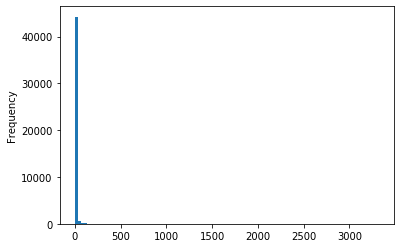

In [63]:
cards.usd.plot.hist(bins = 100)

In [81]:
cards.dtypes

Unnamed: 0          int64
set                object
collectors_num     object
name               object
cost               object
type               object
rarity             object
language           object
artist             object
usd               float64
eur               float64
tix               float64
dtype: object

# My original, not that great, approach

In [11]:
url = r'https://www.scryfall.com'

r = requests.get(url)

data = r.text

soup = BeautifulSoup(data)

In [12]:
print(soup.prettify()[:10])

<!DOCTYPE 


In [67]:
links = soup.find_all('a')

display(f'There are {len(links)} links')

for link in links:
    print(link.get('href'))

'There are 50 links'

#main
#footer
/
/advanced
/docs/syntax
/sets
/random
https://scryfall.com/sets/und
/sets/thb?order=set
/sets/sld?order=spoiled
/register
https://scryfall.com/card/ddu/27/yeva-natures-herald
https://scryfall.com/card/rna/195/prime-speaker-vannifar
https://scryfall.com/card/c13/199/mayael-the-anima
https://scryfall.com/card/chk/121/kiku-nights-flower
https://scryfall.com/card/plc/36/braids-conjurer-adept
https://scryfall.com/card/frf/90/alesha-who-smiles-at-death
https://scryfall.com/card/dka/24/thalia-guardian-of-thraben
/advanced
/docs/syntax
/sets
/account/decks
/random
/bots
/docs/faqs
/blog
https://artgame.scryfall.com
https://tagger.scryfall.com
/settings/profile
/register
/docs/terms
/contact
/docs/privacy
/docs/api
/docs/api/cards
/docs/api/images
/docs/api/bulk-data
/blog/category/api
https://twitter.com/scryfall
https://www.reddit.com/user/Scryfall/
https://github.com/scryfall
#
#
None
None
None
None
/admin/cards/new
/admin
/settings/preferences


Ok, that's a lot of pages. The "sets" page looks promising. I think that will have every card. Let's go there!

In [13]:
r = requests.get(f'{url}/sets')

sets_data = r.text

sets_soup = BeautifulSoup(sets_data)

In [14]:
# print(sets_soup.prettify())

In [15]:
sets_links = sets_soup.find_all('a')

display(f'There are {len(sets_links)} links')

for link in sets_links[:10]:
    print(link.get('href'))

'There are 3353 links'

#main
#footer
/
/advanced
/docs/syntax
/sets
/random
/account/decks
/settings
/advanced


Hmm, a lot of repeats and a lot of different formats. Let's fix all the links to be the full link, then create a list without duplicates.

In [16]:
def fix_link(link):
    try:
        if link[:5] == 'https':
            return link
        elif link[0] == '/':
            return f'{url}{link}'
    except:
        print('Empty Link')

In [17]:
sets_list = [link.get('href') for link in sets_links]

fixed_sets_list = [fix_link(string) for string in sets_list]
fixed_sets_list = list(set(fixed_sets_list))
fixed_sets_list[:10]

Empty Link
Empty Link
Empty Link
Empty Link


['https://scryfall.com/sets/hou',
 'https://www.scryfall.com/sets/m15/ko',
 'https://scryfall.com/sets/pvan',
 'https://www.scryfall.com/sets/rin/it',
 'https://www.scryfall.com/sets/sth/ja',
 'https://www.scryfall.com/sets/aer/zht',
 'https://scryfall.com/sets/10e',
 'https://scryfall.com/sets/pres',
 'https://www.scryfall.com/sets/pkld',
 'https://www.scryfall.com/sets/e01']

Looking good. A few more things to work on:
1. Some have www and some don't. Let's add that to all of them.
2. There will be more duplicates after we do that. (I suspect that we could just drop all that don't have www, but it doesn't hurt to be careful.
3. There are a few bad ones, like reddit and none. Let's lose those as well.

In [18]:
fixed_sets_list.remove(None)

In [20]:
fixed_sets_list[:10]

['https://scryfall.com/sets/hou',
 'https://www.scryfall.com/sets/m15/ko',
 'https://scryfall.com/sets/pvan',
 'https://www.scryfall.com/sets/rin/it',
 'https://www.scryfall.com/sets/sth/ja',
 'https://www.scryfall.com/sets/aer/zht',
 'https://scryfall.com/sets/10e',
 'https://scryfall.com/sets/pres',
 'https://www.scryfall.com/sets/pkld',
 'https://www.scryfall.com/sets/e01']

In [21]:
# Join them all into one string
# Seems easer to do regex when it's all one string. 
# Should investigate this more. Am I just bad, or is this a good way to do it?

csv = ','.join(fixed_sets_list)

csv = re.sub(r'/scryfall', r'/www.scryfall', csv)

fixed_sets_list = csv.split(',')

In [22]:
fixed_sets_list = list(set(fixed_sets_list))

In [25]:
fixed_sets_list[:10]

['https://www.scryfall.com/sets/m15/ko',
 'https://www.scryfall.com/sets/rin/it',
 'https://www.scryfall.com/sets/sth/ja',
 'https://www.scryfall.com/sets/aer/zht',
 'https://www.scryfall.com/sets/pkld',
 'https://www.scryfall.com/sets/e01',
 'https://www.scryfall.com/sets/gtc/ja',
 'https://www.scryfall.com/sets/gk2/de',
 'https://www.scryfall.com/sets/arb/ru',
 'https://www.scryfall.com/sets/nem/it']

Ok, almost there. There's still a few unwanted sites in there. Let's get rid of every site which doesn't have a "www.scryfall.com/sets" in it

In [26]:
csv = ','.join(fixed_sets_list)

regex = r'[^,]*www.scryfall.com/sets[^,]*'

csv = re.findall(regex, csv)

fixed_sets_list = csv

In [ ]:
fixed_sets_list[:10]

Now, I know this isn't yet correct, because on that page it says that there's 579 sets. So what's gone wrong?

Well, some of the set pages have additional "/" after the set designation. So it's some kind of subpage. 

Oh, I see, it's for each language. Well, I believe the default for each is English, so let's get rid of everything after the set description.

In [ ]:
csv = ','.join(fixed_sets_list)

regex = r'(/sets/[^/,]*?)/[^/,]*?,'

# re.findall(regex, csv, flags = re.VERBOSE)

csv = re.sub(regex, r'\1,', csv, flags = re.VERBOSE)

final_sets_list = csv.split(',')

In [ ]:
final_sets_list[:10]

YES! Looking good! Now I just need to remove the duplicates again (could have waited until now, but I just like cleaning things).

In [ ]:
final_sets_list = list(set(final_sets_list))

In [ ]:
final_sets_list[:10]

In [27]:
So close!!! We ended up with 574 links. But there are actually 579 sets (According to the bottom of the page). We'll I'm not sure what I missed, but I think there's a better way to handle this stuff.

['https://www.scryfall.com/sets/m15/ko',
 'https://www.scryfall.com/sets/rin/it',
 'https://www.scryfall.com/sets/sth/ja',
 'https://www.scryfall.com/sets/aer/zht',
 'https://www.scryfall.com/sets/pkld',
 'https://www.scryfall.com/sets/e01',
 'https://www.scryfall.com/sets/gtc/ja',
 'https://www.scryfall.com/sets/gk2/de',
 'https://www.scryfall.com/sets/arb/ru',
 'https://www.scryfall.com/sets/nem/it']

Now, I know this isn't yet correct, because on that page it says that there's 579 sets. So what's gone wrong?

Well, some of the set pages have additional "/" after the set designation. So it's some kind of subpage. 

Oh, I see, it's for each language. Well, I believe the default for each is English, so let's get rid of everything after the set description.

In [29]:
csv = ','.join(fixed_sets_list)

regex = r'(/sets/[^/,]*?)/[^/,]*?,'

# re.findall(regex, csv, flags = re.VERBOSE)

csv = re.sub(regex, r'\1,', csv, flags = re.VERBOSE)

final_sets_list = csv.split(',')

In [30]:
final_sets_list[:10]

['https://www.scryfall.com/sets/m15',
 'https://www.scryfall.com/sets/rin',
 'https://www.scryfall.com/sets/sth',
 'https://www.scryfall.com/sets/aer',
 'https://www.scryfall.com/sets/pkld',
 'https://www.scryfall.com/sets/e01',
 'https://www.scryfall.com/sets/gtc',
 'https://www.scryfall.com/sets/gk2',
 'https://www.scryfall.com/sets/arb',
 'https://www.scryfall.com/sets/nem']

YES! Looking good! Now I just need to remove the duplicates again (could have waited until now, but I just like cleaning things).

In [31]:
final_sets_list = list(set(final_sets_list))

In [33]:
final_sets_list[:10]

['https://www.scryfall.com/sets/fmb1',
 'https://www.scryfall.com/sets/rna',
 'https://www.scryfall.com/sets/tgn2',
 'https://www.scryfall.com/sets/mb1',
 'https://www.scryfall.com/sets/m12',
 'https://www.scryfall.com/sets/pemn',
 'https://www.scryfall.com/sets/f05',
 'https://www.scryfall.com/sets/f02',
 'https://www.scryfall.com/sets/prwk',
 'https://www.scryfall.com/sets/v10']

So close!!! We ended up with 574 links. But there are actually 579 sets (According to the bottom of the page). We'll I'm not sure what I missed, but I think there's a better way to handle this stuff.